# Data cleaning and Reduction
#### Final datasets

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import astropy
from astropy.time import Time
from astropy.coordinates import EarthLocation, AltAz, get_body
import astropy.units as u
from augerscalerpy.scaler_cleaning import scaler_clean, plot_data
from augerscalerpy.plot_config import configure_plots
from IPython.display import Image

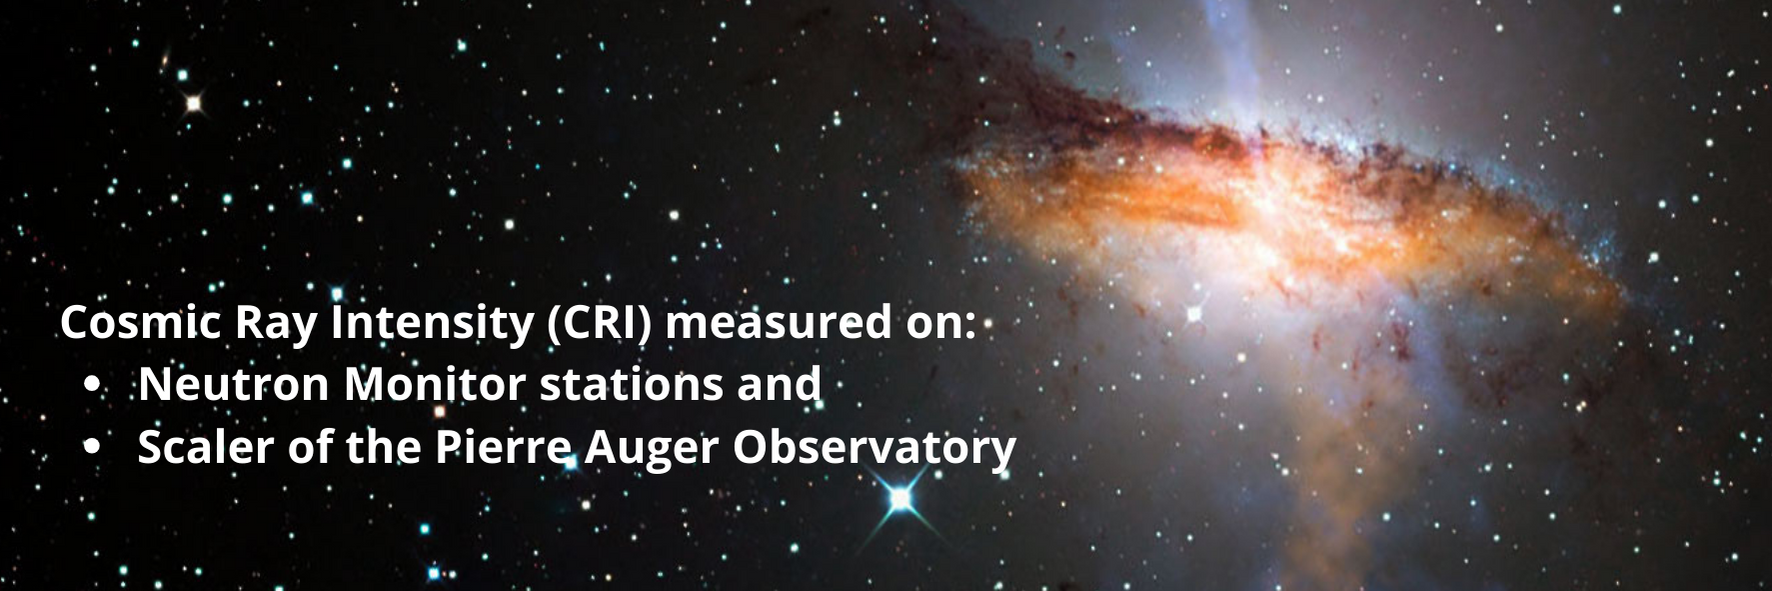

In [8]:
ruta_imagen_local = '/home/jennifer/Documentos/msc_tesis/P1.png'

Image(filename=ruta_imagen_local)

# CRI

## Datos Pierre Auger

Hay valores nulos en el DataFrame.
Aún hay valores NaN en el DataFrame después de la interpolación.
No hay valores NaN en el DataFrame después del llenado.
No hay valores NaN en el DataFrame después del proceso.


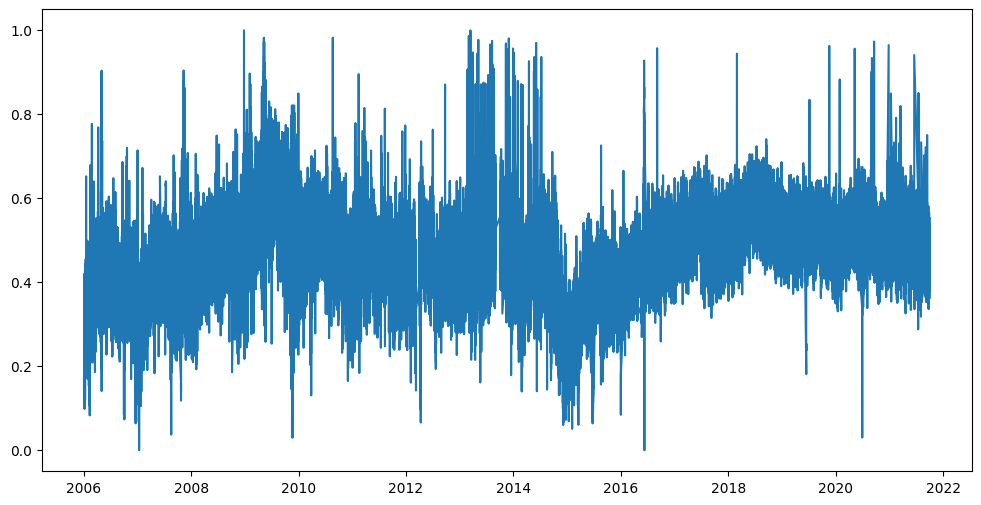

In [12]:

scaler300s = pd.read_csv("scaler_datasets/scaler_300s_FINAL.csv")
#COMPROBANDO SI HAY VALORES NULOS
if scaler300s.isnull().values.any():
    print("Hay valores nulos en el DataFrame.")

# Reemplazar los ceros por NaN
scaler300s.replace(0, np.nan, inplace=True)

# Realizar la interpolación
scaler300s.interpolate(method='nearest', limit_direction='both', inplace=True)

# Comprobar si aún hay valores NaN después de la interpolación
if scaler300s.isnull().values.any():
    print("Aún hay valores NaN en el DataFrame después de la interpolación.")
else:
    print("No hay valores NaN en el DataFrame después de la interpolación.")

scaler300s.fillna(scaler300s.mean(), inplace=True)

if scaler300s.isnull().values.any():
    print("Aún hay valores NaN en el DataFrame después del llenado.")
else:
    print("No hay valores NaN en el DataFrame después del llenado.")
###############################
#CONVERTIR LOS DATOS DE GPS A UTC
scaler300s.reset_index(inplace=True)       ####################################################################################

# Ajusta el desfase de tiempo GPS a UTC
gps_to_utc_offset = 315964786  #diferencia e segundos

# Aplica la transformación de tiempo GPS a UTC
scaler300s['Date'] = pd.to_datetime(scaler300s['Date'] + gps_to_utc_offset, unit='s', origin='unix')

###############################
# CALCULAR LA MEDIANA DE LOS DATOS
# Método de normalización min-max
median = scaler300s['ScalerCorr'].median()

# Calcular el rango intercuartil (IQR)
Q1 = scaler300s['ScalerCorr'].quantile(0.05) # por debajo del 5%
Q3 = scaler300s['ScalerCorr'].quantile(0.95) # por encima del 95%
IQR = Q3 - Q1

# Definir los límites para los valores atípicos
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Reemplazar los valores atípicos con la mediana
scaler300s['ScalerCorr'] = np.where((scaler300s['ScalerCorr'] < lower_limit) | (scaler300s['ScalerCorr'] > upper_limit), median, scaler300s['ScalerCorr'])

scaler_com = scaler300s.copy() #Crear copias del dataset para cálculos siguientes
scaler_gen = scaler300s.copy()
#####

## RESAMPLING A 3H PARA AJUSTAR LA SERIES DE TIEMPO CON LOS DETECTORES DE NEUTRONES
auger = scaler_com[['Date', 'ScalerCorr']] #Extraigo las dos columnas de interés.
auger = auger.rename(columns={'Date': 'date', 'ScalerCorr':'counts/s'})
#auger = pd.to_datetime(auger['date'])

############################################## DESCOMENTAR PARA RESAMPLING ########################################
#auger.set_index('date', inplace=True)

# Resample a un valor diario y calcula el promedio
#DESCOMENTAR CUANDO SE QUIERA HACER EL RESAMPLING AQUÍ (puede  generar valores NaN)
#auger = auger.resample('3H').mean()
############################################## DESCOMENTAR PARA RESAMPLING ########################################
#
##################################### DESCOMENTAR PARA DATASET NORMALIZADO ########################################
# NORMALIZANDO CON MIN-MAX
# Calcular el valor mínimo y máximo de la columna
min_val = auger['counts/s'].min()
max_val = auger['counts/s'].max()

# Aplicar la normalización min-max
auger['counts/s'] = (auger['counts/s'] - min_val) / (max_val - min_val)
if auger.isnull().values.any():
    print("Hay valores NaN en el DataFrame después del proceso.")
else:
    print("No hay valores NaN en el DataFrame después del proceso.")
#auger.reset_index(inplace=True)
##################################### DESCOMENTAR PARA DATASET NORMALIZADO ########################################

plt.figure(figsize=(12, 6))
plt.plot(auger['date'],auger['counts/s'])

#auger = pd.to_datetime(auger['date'])
auger.to_csv('auger_cleaned_300s_NORMALIZADO.csv', index=False)



In [3]:
# ¿La serie de tiempo de los datos es continua?
import pandas as pd
# Ordena el DataFrame por la columna de tiempo.
scaler300s = scaler300s.sort_values(by=['Date'])
# Calcula la diferencia entre los valores de tiempo adyacentes.
time_diff = scaler300s['Date'].diff()
# Define un timedelta de 5 minutos (300 segundos).
five_minutes = pd.Timedelta(minutes=5)
# Verifica si la diferencia es aproximadamente igual a 5 minutos (300 segundos).
is_continuous = (time_diff == five_minutes)
# La variable 'is_continuous' contendrá valores True para filas con diferencias de 5 minutos
# y False para aquellas que no cumplan con esa condición.
# Puedes contar los valores True y False para verificar si los datos son continuos en el tiempo.
count_continuous = is_continuous.sum()
count_not_continuous = len(is_continuous) - count_continuous
print("Número de intervalos de 5 minutos:", count_continuous)
print("Número de intervalos que no son de 5 minutos:", count_not_continuous)

Número de intervalos de 5 minutos: 1532190
Número de intervalos que no son de 5 minutos: 865


## Datos de la estación Neutron Monitor - Olulu

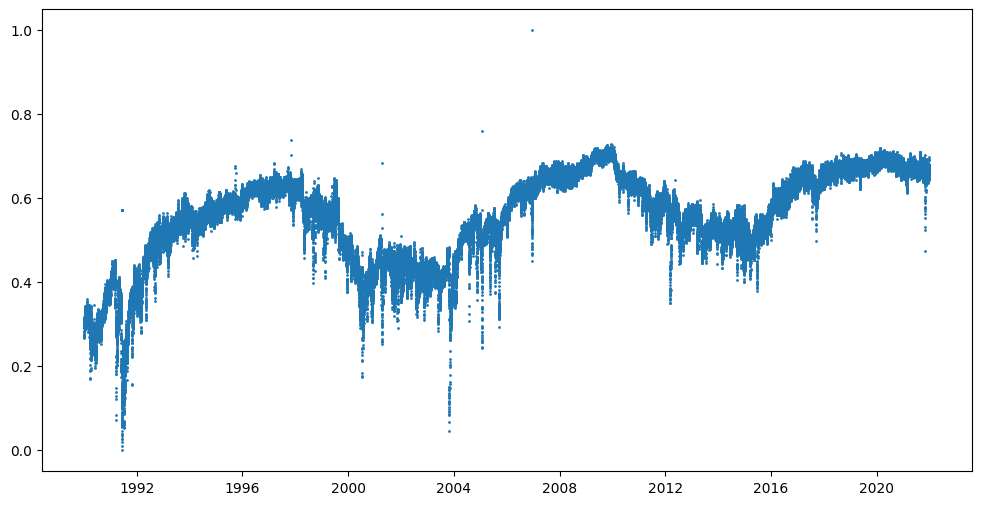

In [4]:
CRIdf = pd.read_csv('solar_parameters/oulu.csv')
CRIdf['CorrectedCountRate[cts/min]'] = pd.to_numeric(CRIdf['CorrectedCountRate[cts/min]'], errors='coerce')
CRIdf['Timestamp'] = pd.to_datetime(CRIdf['Timestamp'])
CRIdf.set_index('Timestamp', inplace=True) # Convierto la columna Date en índices esto los preserva
#SOLO PARA ATHENAS COMENTAR PARA HACERLO CON LAS OTRAS NM
#OJO
# Define tus fechas de inicio y fin
#start_date = '2006-01-01'
end_date = '2021-12-31'
# Corta el DataFrame a tu intervalo de fechas
#CRIdf = CRIdf.loc[start_date:end_date]
#########################################################
if CRIdf.isnull().values.any():
    print("Hay valores nulos en el DataFrame.")
CRIdf.replace(0, np.nan, inplace=True)
CRIdf.interpolate(method='nearest', limit_direction='both', inplace=True)
median = CRIdf['CorrectedCountRate[cts/min]'].median()
Q1 = CRIdf['CorrectedCountRate[cts/min]'].quantile(0.10) # por debajo del 10%
Q3 = CRIdf['CorrectedCountRate[cts/min]'].quantile(0.90) # por encima del 90%
IQR = Q3 - Q1
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR
# Reemplazar los valores atípicos con la mediana
CRIdf['CorrectedCountRate[cts/min]'] = np.where((CRIdf['CorrectedCountRate[cts/min]'] < lower_limit) | (CRIdf['CorrectedCountRate[cts/min]'] > upper_limit), median, CRIdf['CorrectedCountRate[cts/min]'])
CRIdf.reset_index(inplace=True)
oulu_com = CRIdf.copy() #Crear copias del dataset para cálculos siguientes
oulu_gen = CRIdf.copy()
#####
## RESAMPLING A 3H PARA AJUSTAR LA SERIES DE TIEMPO CON LOS DETECTORES DE NEUTRONES
oulu = oulu_com[['Timestamp', 'CorrectedCountRate[cts/min]']] #Extraigo las dos columnas de interés.
oulu = oulu.rename(columns={'Timestamp': 'date', 'CorrectedCountRate[cts/min]': 'counts/s'})
#oulu.set_index('date', inplace=True)
# Resample a un valor diario y calcula el promedio
#oulu = oulu.resample('3H').mean()
oulu
# NORMALIZANDO CON MIN-MAX
# Calcular el valor mínimo y máximo de la columna
min_val = oulu['counts/s'].min()
max_val = oulu['counts/s'].max()
# Aplicar la normalización min-max
oulu['counts/s'] = (oulu['counts/s'] - min_val) / (max_val - min_val)
plt.figure(figsize=(12, 6))
plt.scatter(oulu['date'],oulu['counts/s'], s=1)

## DATASETS DE LA NMDB:


In [7]:
################ CON EL PORCENTAJE DE DESVIACIÓN DE LA MEDIANA

def nmdb_clean(filename):
    column_name = "counts/s"
    skip_rows = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 22, 23]
    df = pd.read_csv(filename, delimiter=';', skiprows=skip_rows, header=None)
    df.columns = ['date', 'counts/s']
    df['date'] = pd.to_datetime(df['date'])
    df['counts/s'] = df['counts/s'].astype('float64')
    print(len(df))
    df.set_index('date', inplace=True) # Convierto la columna Date en índices esto los preserva
    #SOLO PARA ATHENAS COMENTAR PARA HACERLO CON LAS OTRAS NM
    #OJO
    # Define tus fechas de inicio y fin
    #start_date = '2006-01-01'
    #end_date = '2021-12-31'
    # Corta el DataFrame a tu intervalo de fechas
    #df = df.loc[start_date:end_date]
####################################################################################################################################
    if df.isnull().values.any():
        print("Hay valores nulos en el DataFrame.")
    df.replace(0, np.nan, inplace=True)
    df.interpolate(method='nearest', limit_direction='both', inplace=True)
    median = df[column_name].median()
    Q1 = df[column_name].quantile(0.10) # por debajo del 10%
    Q3 = df[column_name].quantile(0.90) # por encima del 90%
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    # Reemplazar los valores atípicos con la mediana
    df[column_name] = np.where((df[column_name] < lower_limit) | (df[column_name] > upper_limit), median, df[column_name])
    df.reset_index(inplace=True)
    # NORMALIZANDO CON MIN-MAX
    # Calcular el valor mínimo y máximo de la columna
    min_val = df[column_name].min()
    max_val = df[column_name].max()
    # Aplicar la normalización min-max
    df[column_name] = (df[column_name] - min_val) / (max_val - min_val)
    print(len(df))
          
    return df

In [6]:
# DESCOMENTAR CUANDO SE VAYA A EXTRAER EL DATASET DE ATENAS
#athenas = nmdb_clean('nm_data/long_files/athenas_NMDB.txt')

62228
45401


In [8]:
mexico = nmdb_clean('nm_data/long_files/mexico_NMDB.txt')
roma = nmdb_clean('nm_data/long_files/rome_NMDB.txt')
tsumeb = nmdb_clean('nm_data/long_files/tsumeb_NMDB.txt')

92440
92440
67423
67423
75223
75223


## Crea el dataset NMs + Auger con resolución de 3h
##### Nota(Realice previamente el resampling de 3h a Auger)

In [10]:
import pandas as pd

# Supongamos que tienes 6 DataFrames llamados oulu, auger, mexico, athenas, roma y tsumeb
combined_df = oulu.copy()  # Inicializar el DataFrame combinado con oulu
dataframes = [(auger, "_2"), (mexico, "_3"), (athenas, "_4"), (roma, "_5"), (tsumeb, "_6")]

for df, suffix in dataframes:
    df['date'] = df['date'].dt.tz_localize(None).dt.tz_localize('UTC')
    # Combinar los DataFrames usando merge_asof
    combined_df = pd.merge_asof(combined_df, df, on="date", suffixes=("", suffix))

combined_df = combined_df.rename(columns={'counts/s': 'oulu','counts/s_2': 'auger', 'counts/s_3': 'mexico', 'counts/s_4': 'athenas','counts/s_5': 'roma', 'counts/s_6': 'tsumeb'})

#DESCOMENTE SI QUIERE GUARDAR EL DATASET QUE SE HA CREADO
#combined_df.to_csv('CRI_auger_NM_3H_NORM.csv', index=False)
combined_df

date      oulu     auger    mexico   athenas  \
0     1990-01-01 00:00:00+00:00  0.268488       NaN  0.342175       NaN   
1     1990-01-01 03:00:00+00:00  0.269868       NaN  0.348069       NaN   
2     1990-01-01 06:00:00+00:00  0.277318       NaN  0.344023       NaN   
3     1990-01-01 09:00:00+00:00  0.275110       NaN  0.339687       NaN   
4     1990-01-01 12:00:00+00:00  0.275938       NaN  0.351850       NaN   
...                         ...       ...       ...       ...       ...   
93491 2021-12-30 09:00:00+00:00  0.665563  0.484668  0.617640  0.599456   
93492 2021-12-30 12:00:00+00:00  0.667494  0.484668  0.628981  0.598872   
93493 2021-12-30 15:00:00+00:00  0.658113  0.484668  0.628969  0.556679   
93494 2021-12-30 18:00:00+00:00  0.646247  0.484668  0.627725  0.537430   
93495 2021-12-30 21:00:00+00:00  0.653146  0.484668  0.619403  0.551040   

           roma    tsumeb  
0           NaN       NaN  
1           NaN  0.246244  
2           NaN  0.247264  
3           NaN  0.241228  
4           NaN  0.247043  
...         ...       ...  
93491  0.388935  0.562495  
93492  0.386330  0.562495  
93493  0.383259  0.562495  
93494  0.378829  0.562495  
93495  0.381070  0.562495  

[93496 rows x 7 columns]

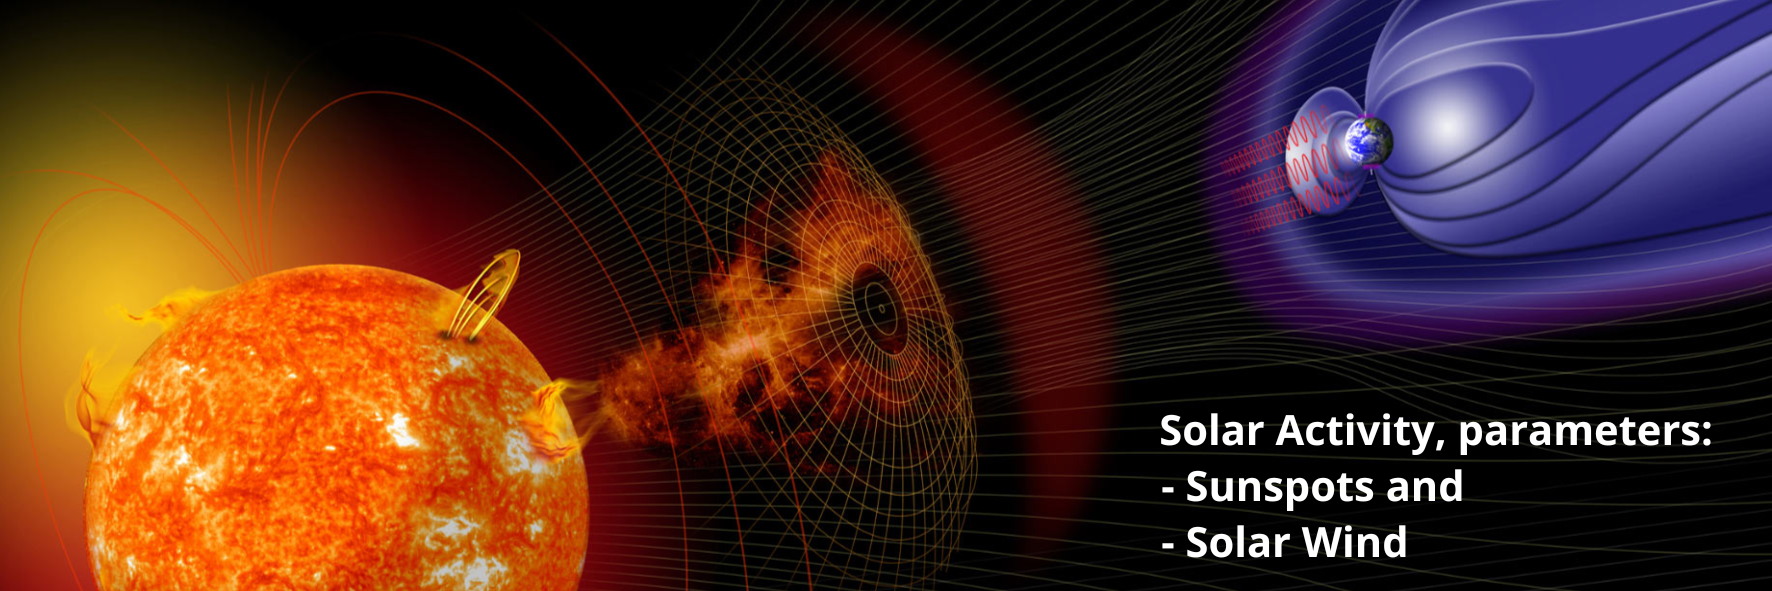

In [7]:
ruta_imagen_local = '/home/jennifer/Documentos/msc_tesis/P2.png'

Image(filename=ruta_imagen_local)

# Histórico del número de manchas solares
#### Fuente: https://www.sidc.be/SILSO/datafiles

In [47]:
SSN = pd.read_csv('solar_parameters/SN_d_tot_V2.0.csv', delimiter=';')
SSN = SSN.rename(columns={'date': 'Año', 'xx': 'Mes','xx.1':'Dia'})
# Crea una nueva columna "FechaStr" con el formato correcto (YYYY-MM-DD)
SSN['FechaStr'] = SSN['Año'].astype(str) + '-' + SSN['Mes'].astype(str) + '-' + SSN['Dia'].astype(str)
# Convierte la columna "FechaStr" en formato datetime
SSN['date'] = pd.to_datetime(SSN['FechaStr'], errors='coerce')
# Eliminar la columna temporal "FechaStr"
del SSN['FechaStr']
del SSN['Año']
del SSN['Mes']
del SSN['Dia']
#del SSN['date']


SSN['sunspots'] = np.where(SSN['sunspots'] == -1.0, np.nan, SSN['sunspots']) #Convirtiendo excesos en NAN
avg_value = SSN['sunspots'].mean(skipna=True) #Calculando el promedio ignorando estos excesos
#SSN['sunspots'] = SSN['sunspots'].replace(0, np.nan) #Convirtiendo ceros en NAN
SSN['sunspots'] = np.where(SSN['sunspots'] > 50.0, avg_value, SSN['sunspots']) #Convirtiendo excesos en NAN
#SSN['sunspots'].fillna(avg_value, inplace=True) # Llenando los NAN por este valor promedio

# Ahora el DataFrame contiene una nueva columna "Fecha" en formato datetime
SN = SSN[['date', 'sunspots']]
SN

date  sunspots
0     1818-01-01       NaN
1     1818-01-02       NaN
2     1818-01-03       NaN
3     1818-01-04       NaN
4     1818-01-05       NaN
...          ...       ...
75143 2023-09-26      17.2
75144 2023-09-27      18.3
75145 2023-09-28       9.4
75146 2023-09-29       9.0
75147 2023-09-30      10.8

[75148 rows x 2 columns]

In [48]:
# Importar la biblioteca necesaria
from sklearn.preprocessing import MinMaxScaler

# Crear el objeto MinMaxScaler
scaler = MinMaxScaler()

# Ajustar y transformar los datos
SSN['sunspots'] = scaler.fit_transform(SSN[['sunspots']])

# Ahora la columna 'sunspots' está normalizada
SN = SSN[['date', 'sunspots']]
SN


date  sunspots
0     1818-01-01       NaN
1     1818-01-02       NaN
2     1818-01-03       NaN
3     1818-01-04       NaN
4     1818-01-05       NaN
...          ...       ...
75143 2023-09-26  0.360587
75144 2023-09-27  0.383648
75145 2023-09-28  0.197065
75146 2023-09-29  0.188679
75147 2023-09-30  0.226415

[75148 rows x 2 columns]

## Histórico del número de Viento Solar
#### Fuente: https://spdf.gsfc.nasa.gov/pub/data/omni/low_res_omni/omni_m_daily.dat

In [50]:
SW = pd.read_csv('solar_parameters/omni_m_daily.dat', sep=r'\s+', engine='python')
SW['solarw'] = np.where(SW['solarw'] == 9999.0, np.nan, SW['solarw']) #Convirtiendo excesos en NAN
SW['solarw'] = SW['solarw'].replace(0, np.nan) #Convirtiendo ceros en NAN
avg_value = SW['solarw'].mean(skipna=True) #Calculando el promedio ignorando estos excesos

SW['solarw'].fillna(avg_value, inplace=True) # Llenando los NAN por este valor promedio

SW['date'] = pd.to_datetime(SW['year'].astype(str) + SW['day'].astype(str), format='%Y%j') #Estableciendo el formato de fecha datetime
SW = SW[['date', 'solarw']]
SW

date      solarw
0     1963-01-01  435.232565
1     1963-01-02  435.232565
2     1963-01-03  435.232565
3     1963-01-04  435.232565
4     1963-01-05  435.232565
...          ...         ...
22275 2023-12-27  435.232565
22276 2023-12-28  435.232565
22277 2023-12-29  435.232565
22278 2023-12-30  435.232565
22279 2023-12-31  435.232565

[22280 rows x 2 columns]

In [51]:
# Importar la biblioteca necesaria
from sklearn.preprocessing import MinMaxScaler

# Crear el objeto MinMaxScaler
scaler = MinMaxScaler()

# Ajustar y transformar los datos
SW['solarw'] = scaler.fit_transform(SW[['solarw']])

# Ahora la columna 'solarw' está normalizada
SW = SW[['date', 'solarw']]
SW


date    solarw
0     1963-01-01  0.299053
1     1963-01-02  0.299053
2     1963-01-03  0.299053
3     1963-01-04  0.299053
4     1963-01-05  0.299053
...          ...       ...
22275 2023-12-27  0.299053
22276 2023-12-28  0.299053
22277 2023-12-29  0.299053
22278 2023-12-30  0.299053
22279 2023-12-31  0.299053

[22280 rows x 2 columns]

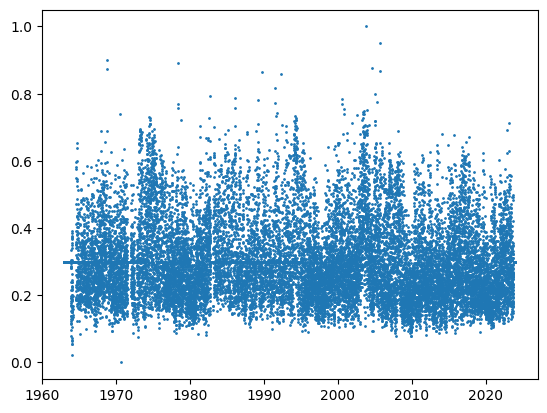

In [52]:
plt.scatter(SW['date'], SW['solarw'],s=1)

## Histórico del Pierre Auger desde 2006

In [45]:
auger.set_index('date', inplace=True)
scaler_daily = auger.resample('D').mean()
# Reinicia el índice para que 'Date' vuelva a ser una columna
scaler_daily.reset_index(inplace=True)
scaler_CRI = scaler_daily[['date', 'counts/s']]
scaler_CRI = scaler_CRI.rename(columns={'date': 'date', 'counts/s': 'CRI'})
scaler_CRI

date       CRI
0    2005-12-31 00:00:00+00:00  0.142186
1    2006-01-01 00:00:00+00:00  0.237439
2    2006-01-02 00:00:00+00:00  0.228973
3    2006-01-03 00:00:00+00:00  0.256483
4    2006-01-04 00:00:00+00:00  0.245824
...                        ...       ...
5748 2021-09-26 00:00:00+00:00  0.399665
5749 2021-09-27 00:00:00+00:00  0.422951
5750 2021-09-28 00:00:00+00:00  0.450302
5751 2021-09-29 00:00:00+00:00  0.441430
5752 2021-09-30 00:00:00+00:00  0.469676

[5753 rows x 2 columns]

In [53]:
scaler_CRI['date'] = pd.to_datetime(scaler_CRI['date']).dt.strftime('%Y-%m-%d')
SN['date'] = pd.to_datetime(SN['date']).dt.strftime('%Y-%m-%d')
SN = SN[['date', 'sunspots']]
SW['date'] = pd.to_datetime(SW['date']).dt.strftime('%Y-%m-%d')
SN

/tmp/ipykernel_32561/3897781618.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SN['date'] = pd.to_datetime(SN['date']).dt.strftime('%Y-%m-%d')


date  sunspots
0      1818-01-01       NaN
1      1818-01-02       NaN
2      1818-01-03       NaN
3      1818-01-04       NaN
4      1818-01-05       NaN
...           ...       ...
75143  2023-09-26  0.360587
75144  2023-09-27  0.383648
75145  2023-09-28  0.197065
75146  2023-09-29  0.188679
75147  2023-09-30  0.226415

[75148 rows x 2 columns]

In [54]:
scaler_CRI

date       CRI
0     2005-12-31  0.142186
1     2006-01-01  0.237439
2     2006-01-02  0.228973
3     2006-01-03  0.256483
4     2006-01-04  0.245824
...          ...       ...
5748  2021-09-26  0.399665
5749  2021-09-27  0.422951
5750  2021-09-28  0.450302
5751  2021-09-29  0.441430
5752  2021-09-30  0.469676

[5753 rows x 2 columns]

In [55]:
# Lista de DataFrames a fusionar
dataframes = [SN, SW, scaler_CRI]  # Agrega todos tus DataFrames a esta lista

# Columna en común para fusionar
common_column = 'date'

# Inicializa el DataFrame combinado con el primero de la lista
auger_solar_parameter = dataframes[0]

# Fusiona los DataFrames usando pd.merge_asof
for df in dataframes[1:]:
    # Asegúrate de que la columna 'date' en df tenga el mismo formato
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    auger_solar_parameter['date'] = pd.to_datetime(auger_solar_parameter['date'], format='%Y-%m-%d')
    auger_solar_parameter = pd.merge_asof(auger_solar_parameter, df, on=common_column)

#auger_solar_parameter.to_csv('auger_solar_parameter_NORM.csv', index=False)
auger_solar_parameter

date  sunspots    solarw       CRI
0     1818-01-01       NaN       NaN       NaN
1     1818-01-02       NaN       NaN       NaN
2     1818-01-03       NaN       NaN       NaN
3     1818-01-04       NaN       NaN       NaN
4     1818-01-05       NaN       NaN       NaN
...          ...       ...       ...       ...
75143 2023-09-26  0.360587  0.332099  0.469676
75144 2023-09-27  0.383648  0.323457  0.469676
75145 2023-09-28  0.197065  0.248148  0.469676
75146 2023-09-29  0.188679  0.293827  0.469676
75147 2023-09-30  0.226415  0.270370  0.469676

[75148 rows x 4 columns]

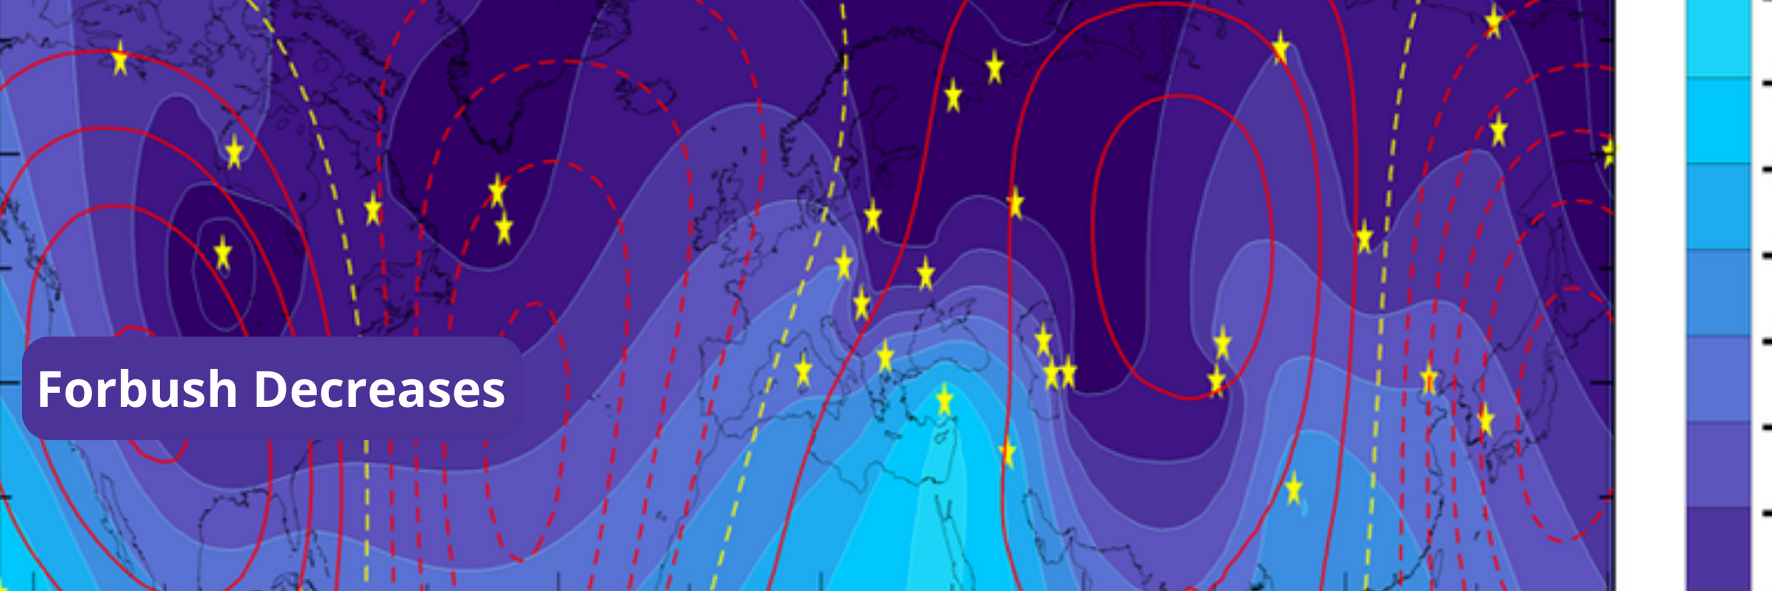

In [6]:
ruta_imagen_local = '/home/jennifer/Documentos/msc_tesis/P3.png'

Image(filename=ruta_imagen_local)

# Datos de Forbush Decreases by  IZMIRAN
#### Códigos inactivos por pesados.

# Extracción de información de la base de datos extendida del IZMIRAN
#### Criterios:
- Otype = 1
- Qs = 4 o 5
- Rango de años = 2006-2021 (Para contrastar con el Observatorio Pierre Auger)
- Códigos inactivos. Activar si se requiere la extracción nuevamente.

##### 
- El siguiente código extrae los datos... se deja inactivo porque es muy pesado. Ya se guardó el dataset con esta información y en la siguiente celda silamente se importa del directorio donde quedó alojado.

### Eventos Forbush seleccionados para el análisis con los datos del Observatorio Pierre Auger